# Univariate time series forecasting with LSTM
This tutorial example presents how to perform forecasts for an univariate time series while using a LSTM neural network.  In this example, we use a simple sine-like signal. Run it now in [Google Colab](https://drive.google.com/file/d/1xEYbbCneMCI_hBLajNyJp6riSToWExZj/view?usp=sharing).

### Import libraries
Import the various libraries that will be employed in this example.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

### Import from pytagi
From pytagi, we need to import several classes that will be reused in this example. Notably, we import different neural network layers, a normalizer to normalize data, an exponential scheduler for decaying observation noise variances.

In [2]:
import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential

### Read data
The raw `.csv` data is saved in a dataframe using the Panda external library. The data can be found in the [Github reposetory](https://github.com/lhnguyen102/cuTAGI/tree/main/data/toy_time_series).

In [3]:
project_root = Path.cwd().resolve().parents[1]
# Training data
train_data_file = str(project_root / "../data/toy_time_series/x_train_sin_data.csv")
train_data = pd.read_csv(train_data_file, skiprows=1, delimiter=",", header=None)
# Test data
test_data_file = str(project_root / "../data/toy_time_series/x_test_sin_data.csv")
test_data = pd.read_csv(test_data_file, skiprows=1, delimiter=",", header=None)


### Standardize data
Standardize data to make the training data having zero mean and unit standard deviation

In [4]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.values)
test_data = scaler.transform(test_data.values)

### Create dataset using sliding windows
We obtain (input, output) samples using sliding windows

In [5]:
# Sliding_window function
def create_dataset_sliding_window(data, look_back):
	dataX, dataY = [], []
	for i in range(len(data)-look_back-1):
		input = data[i:i+look_back]
		output = data[i+look_back]
		dataX.append(input)
		dataY.append(output)
	return np.array(dataX), np.array(dataY)

input_seq_len = 10
batch_size = 8

# Create training dataset
trainX, trainY = create_dataset_sliding_window(train_data, look_back = input_seq_len)
trainX = torch.as_tensor(trainX, dtype=torch.float32)
trainY = torch.as_tensor(trainY, dtype=torch.float32)
train_ds = TensorDataset(trainX, trainY)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Create test dataset
testX, testY = create_dataset_sliding_window(test_data, look_back = input_seq_len)
testX = torch.as_tensor(testX, dtype=torch.float32)
testY = torch.as_tensor(testY, dtype=torch.float32)
test_ds = TensorDataset(testX, testY)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Define the neural network architecture
We use 2 LSTM layers following by a linear layer (or fully connected layer)

In [6]:
net = Sequential(
    LSTM(1, 20, input_seq_len),
    LSTM(20, 20, input_seq_len),
    Linear(20 * input_seq_len, 1),
)
# net.to_device("cuda")
net.set_threads(1)
out_updater = OutputUpdater(net.device)

### Training the neural network
The training set is used to optimize the parameters of the LSTM neural network. In this example, the model is trained until it reaches the maximum number of epochs.

In [7]:
mses = []
num_epochs = 50
pbar = tqdm(range(num_epochs), desc="Training Progress")
sigma_v = 1             # Upper bound for the standard deviation for the observation noise
std_obs_noise = 0.3     # Actual standard deviation for the observation noise

for epoch in pbar:

    # Decaying observation's variance
    sigma_v = exponential_scheduler(
        curr_v=sigma_v, min_v=std_obs_noise, decaying_factor=0.99, curr_iter=epoch
    )
    var_y = np.full(
        (batch_size,), sigma_v**2, dtype=np.float32
    )

    for x, y in train_loader:
        # Feed forward
        m_pred, _ = net(x.numpy().flatten())

        # # Update output layer
        out_updater.update(
            output_states=net.output_z_buffer,
            mu_obs=y.numpy().flatten(),
            var_obs=var_y,
            delta_states=net.input_delta_z_buffer,
        )

        # Feed backward
        net.backward()
        net.step()

        # Training metric
        pred = scaler.inverse_transform(m_pred.reshape(-1,1))
        obs = scaler.inverse_transform(y.reshape(-1,1))
        mse = metric.mse(pred, obs)
        mses.append(mse)

    net.reset_lstm_states()
    # # Progress bar
    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs}| mse: {sum(mses)/len(mses):>7.2f}",
        refresh=True,
    )

Epoch 50/50| mse:    0.16: 100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


### Forecast on the test set
We perform recursive 1-step ahead forecasts on the test set and then proceed with un-standardization of the data in order to retreive the original scale of the raw data.

In [8]:
mu_preds = []
var_preds = []
y_test = []

for x, y in test_loader:
    # Predicion
    m_pred, v_pred = net(x.numpy().flatten())

    mu_preds.extend(m_pred)
    var_preds.extend(v_pred + sigma_v**2)
    y_test.extend(y)

mu_preds = np.array(mu_preds)
std_preds = np.array(var_preds).flatten() ** 0.5
y_test = np.array(y_test)

# Unstandardization
mu_preds = scaler.inverse_transform(mu_preds.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
std_preds = std_preds*scaler.scale_

### Plot test predictions
Plot the training data, test data, test predictions along their uncertainty in the original space.

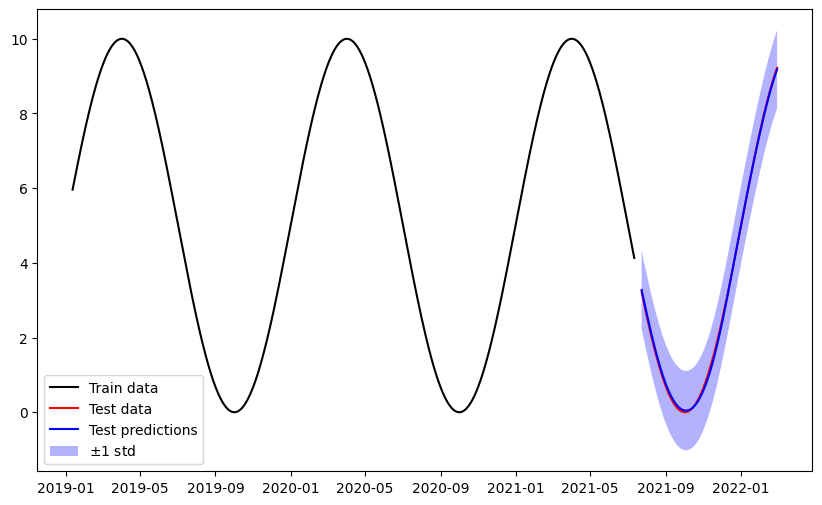

In [9]:
# Training data time
train_data_time_file = str(project_root / "../data/toy_time_series/train_sin_datetime.csv")
train_data_time = pd.read_csv(train_data_time_file, skiprows=1, delimiter=",", header=None)
train_data_time = pd.to_datetime(train_data_time[0])
time_train = train_data_time.values.flatten()[input_seq_len+1:]
train_data = scaler.inverse_transform(train_data[input_seq_len+1:].reshape(-1,1))
# Test data time
test_data_time_file = str(project_root / "../data/toy_time_series/test_sin_datetime.csv")
test_data_time = pd.read_csv(test_data_time_file, skiprows=1, delimiter=",", header=None)
test_data_time = pd.to_datetime(test_data_time[0])
time_test = test_data_time.values.flatten()[input_seq_len+1:]

# Plot
plt.figure(figsize=(10, 6))  #
plt.plot(time_train, train_data, color='black', label="Train data")
plt.plot(time_test, y_test, color='red', label="Test data")
plt.plot(time_test, mu_preds, color='blue', label="Test predictions")
plt.fill_between(
                time_test.flatten(),
                mu_preds.flatten() - std_preds.flatten(),
                mu_preds.flatten() + std_preds.flatten(),
                facecolor="blue",
                alpha=0.3,
                label=r"$\pm 1$ std", 
            )
plt.legend()
plt.show()
